In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from utils.utils_dataset import prepare_non_iid_federated_dataset_for_clustering, prepare_iid_federated_dataset_for_clustering
from utils.utils_train import train_supervised, train_models_in_threads
from utils.utils_plots import plot_first_feature_combinations, plot_first_feature_combinations, plot_results_correct, plot_results_acc


In [2]:
from model.eFedG import eFedG
from model.clustering_operations import ClusteringOps
from model.removal_mechanism import RemovalMechanism 
from model.merging_mechanism import MergingMechanism
from model.math_operations import MathOps
from model.consequence_operations import ConsequenceOps
from model.model_operations import ModelOps
from model.federated_operations import FederalOps
#This is needed for debugging

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
torch.set_num_threads(os.cpu_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu") #
#device = torch.device("cpu")

PyTorch Version: 2.1.2
CUDA Version: 11.8


In [3]:
from scipy.spatial.distance import cdist
def predict_clusters(X, centers):

    # Specify 'euclidean' as the metric for distance calculation
    distances = cdist(X, centers, metric='euclidean')

    return np.argmin(distances, axis=1)

In [4]:
import numpy as np
from collections import Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score


# Function to determine the most common label for each cluster
def determine_cluster_labels(y_true, cluster_assignments):
    cluster_labels = {}
    for cluster in np.unique(cluster_assignments):
        cluster_indices = cluster_assignments == cluster
        # Determine the most common label in the cluster
        most_common_label = Counter(y_true[cluster_indices]).most_common(1)[0][0]
        cluster_labels[cluster] = most_common_label
    return cluster_labels

# Function to remap cluster assignments to the most common labels
def remap_assignments(assignments, cluster_labels):
    remapped_labels = np.array([cluster_labels[cluster] for cluster in assignments])
    return remapped_labels

# Function to compute clustering metrics
def clustering_metrics(X_test, y_test, assignments):
    metrics = {}
    
    metrics['ARI'] = adjusted_rand_score(y_test, assignments)
    print("ARI:", metrics['ARI'])

    metrics['NMI'] = normalized_mutual_info_score(y_test, assignments)
    print("NMI:", metrics['NMI'])

    metrics['ACC'] = accuracy_score(y_test, assignments)
    print("ACC:", metrics['ACC'])

    return metrics

In [5]:
import time
import torch

def run_federated_simulation(rounds, num_clients, local_model_params, federated_model_params, train_loaders, test_dataset, test_loader, debug_flag, profiler_flag, name=None, flag_axis = True, flag_plot = False):

    start_time = time.time()
    federated_model = eFedG(**federated_model_params)
    local_models = [eFedG(**local_model_params) for _ in range(num_clients)]
    
    for round in range(rounds):
        print(f"Round {round}")

        if len(local_models) > 1:
            local_models = train_models_in_threads(local_models, train_loaders, debug_flag)
        else:
            local_models = train_supervised(local_models[0], train_loaders[0], index=1, round=round, debug_flag=debug_flag)
            local_models = [local_models]
            
        federated_model.__init__(**federated_model_params)
        federated_model.set_debugging_flag(debug_flag)
        
        for client_model in local_models:
            federated_model.federal_agent.merge_model_privately(client_model, federated_model.kappa_n, 0)
        federated_model.federal_agent.federated_merging()

        if debug_flag in (1, 8):
            fig = plot_first_feature_combinations((X, y), model=federated_model, num_sigma=2, N_max=federated_model.kappa_n, flag_unlabeled=(debug_flag == 8), flag_axis=True)
            if debug_flag == 8:
                fig.savefig(f".Images/Clustering/Batch/clustering_round{round}_0_merge.svg", bbox_inches='tight')
                fig.savefig(f".Images/Clustering/Batch/clustering_round{round}_0_merge.png", bbox_inches='tight')
                fig.savefig(f".Images/Clustering/Batch/clustering_round{round}_0_merge.pdf", bbox_inches='tight')

            for client_model in local_models:
                client_model.__init__(**local_model_params)
                client_model.set_debugging_flag(debug_flag)
                client_model.federal_agent.merge_model_privately(federated_model, federated_model.kappa_n, 0)
                client_model.n /= num_clients
                client_model.S /= num_clients
                client_model.n_glo/= num_clients
                client_model.S_glo/= num_clients

        print(f"Number of clusters in federated model: {federated_model.c}")
        if debug_flag:
            X_test_tensor, y_test_tensor = test_dataset.tensors
            fig = plot_first_feature_combinations((X_test_tensor.detach().cpu().numpy(), y_test_tensor.detach().cpu().numpy()),
                                                model=federated_model, num_sigma=2, N_max=federated_model.kappa_n, flag_unlabeled=True, flag_axis=flag_axis)
            plt.show()
            
    federated_model.federal_agent.remove_irrelevant_clusters()
    times = time.time() - start_time  # Execution time
    print(f"Time: {times}")
    num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 0).cpu().numpy()

    print(f"Number of clusters in federated model: {num_federated_clusters}")
    X_test_tensor, y_test_tensor = test_dataset.tensors
    if flag_plot:
        fig = plot_first_feature_combinations((X_test_tensor.detach().cpu().numpy(), y_test_tensor.detach().cpu().numpy()),
                                               model=federated_model, num_sigma=2, N_max=federated_model.kappa_n, flag_unlabeled=True, flag_axis=flag_axis)

    X_test_tensor, y_test_tensor = test_dataset.tensors
    X_test_numpy, y_test_numpy = X_test_tensor.detach().cpu().numpy(), y_test_tensor.detach().cpu().numpy()
    final_centers = federated_model.mu[:federated_model.c].detach().cpu().numpy()


    if 0:

        all_test_assignments = []
        for batch, (data, labels) in enumerate(test_loader):
            data, labels = data.to(federated_model.device, non_blocking=True), labels.to(federated_model.device, non_blocking=True)
            _, _, test_assignment = federated_model.forward(data)
            all_test_assignments.append(test_assignment)

        test_assignments = torch.cat(all_test_assignments, dim=0).detach().cpu().numpy()
        cluster_labels = determine_cluster_labels(y_test_numpy, test_assignments)
        mapped_assignments = remap_assignments(test_assignments, cluster_labels)
        metrics = clustering_metrics(X_test_numpy, y_test_numpy, mapped_assignments)
        print(f"Model metrics: {metrics}")
    if 1:
        
        test_assignments = predict_clusters(X_test_numpy, final_centers)
        cluster_labels = determine_cluster_labels(y_test_numpy, test_assignments)
        mapped_assignments = remap_assignments(test_assignments, cluster_labels)
        metrics = clustering_metrics(X_test_numpy, y_test_numpy, mapped_assignments)
        print(f"Outside metrics: {metrics}")
        
        # Plot the results
    if flag_plot:
        plot_results_correct(X_test_numpy, y_test_numpy, final_centers, test_assignments, name, times, method='pca')
        plot_results_acc(X_test_numpy, y_test_numpy, final_centers, test_assignments, name, times, method='pca')

    return test_assignments, num_federated_clusters, times, metrics



In [6]:
import sys
sys.path.append('related_methods/Clustering_kfed')
from fkms.algorithms import kfed

def run_kfed_experiment(train_datasets, test_dataset, num_clients, num_clusters, rounds, name, flag_plot):

    start_time = time.time()
    # Parameters for kFED
    client_data = []
    for i in range(num_clients):
        client_data.append(train_datasets[i].tensors[0].detach().cpu().numpy())

    local_estimates, final_centers = kfed(
        x_dev=client_data, 
        dev_k=num_clusters,  # Clusters per device
        k=num_clusters       # Total number of clusters
    )

    execution_time = time.time() - start_time
   #print("Final cluster centers from kFED:", final_centers)
    print(f"Execution Time: {execution_time:.2f} seconds")

    # Predict cluster assignments for the test data
    X_test_tensor, y_test_tensor = test_dataset.tensors
    X_test_numpy, y_test_numpy = X_test_tensor.detach().cpu().numpy(), y_test_tensor.detach().cpu().numpy()
    test_assignments = predict_clusters(X_test_numpy, final_centers)
    cluster_labels = determine_cluster_labels(y_test_numpy, test_assignments)
    mapped_assignments = remap_assignments(test_assignments, cluster_labels)
    metrics = clustering_metrics(X_test_numpy, y_test_numpy, mapped_assignments)

    # Plot the results
    if flag_plot:
        plot_results_correct(X_test_numpy, y_test_tensor.detach().cpu().numpy(), final_centers, test_assignments, name, execution_time,method='pca')

    return test_assignments, final_centers, execution_time, metrics


In [7]:

import time
import numpy as np
import torch

# Add the custom module path
sys.path.append('related_methods/Clustering_mufc')

# Import your federated clustering function
from mufc_fun import federated_clustering_simple

def run_mufc_experiment(train_datasets, test_dataset, num_clients, num_clusters, max_iters, name, flag_plot):
    start_time = time.time()

    dataset = {'full_data': torch.cat([train_datasets[i].tensors[0] for i in range(num_clients)]).detach().cpu().numpy()}  # Full dataset for reference
    for i in range(num_clients):
        dataset[f'client_{i}'] = train_datasets[i].tensors[0].detach().cpu().numpy()

    # Run federated clustering
    results = federated_clustering_simple(
        dataset=dataset,
        num_clusters=num_clusters,  # Number of clusters
        num_clients=num_clients,  # Number of clients
        split='iid',  # Parameter kept for consistency
        k_prime=num_clusters,  # Set this according to your needs
        max_iters=max_iters  # Number of iterations
    )

    final_centers = results["final_clusters"]

    execution_time = time.time() - start_time
    #print("Final cluster centers from MUFC:", final_centers)
    print(f"Execution Time: {execution_time:.2f} seconds")

    # Predict cluster assignments for the test data
    X_test_tensor, y_test_tensor = test_dataset.tensors
    X_test_numpy, y_test_numpy = X_test_tensor.detach().cpu().numpy(), y_test_tensor.detach().cpu().numpy()
    test_assignments = predict_clusters(X_test_numpy, final_centers)
    
    # Determine the most common label for each cluster
    cluster_labels = determine_cluster_labels(y_test_numpy, test_assignments)

    # Remap cluster assignments to these labels
    mapped_assignments = remap_assignments(test_assignments, cluster_labels)

    # Compute and print clustering metrics
    metrics = clustering_metrics(X_test_numpy, y_test_numpy, mapped_assignments)
    # Plot the results
    if flag_plot:
        plot_results_correct(X_test_numpy, y_test_tensor.detach().cpu().numpy(), final_centers, test_assignments, name, execution_time,method='pca')

    return test_assignments, final_centers, execution_time, metrics


In [8]:
import torch
import numpy as np
import pandas as pd
import os

def run_benchmark_experiment(X, y, local_model_params, federated_model_params, batch_size, feature_dim, num_clients, profiler_flag=False, debug_flag=0, unlabeled=0, name=None, flag_axis=True, flag_noniid=True, flag_plot=False):
    # Initialize dictionaries to store metrics for each method
    results = {
        'BeFedG_CPU': {'Accuracy': [], 'nmi': [], 'ari': [], 'time': [], 'clusters': []},
        'BeFedG_GPU': {'Accuracy': [], 'nmi': [], 'ari': [], 'time': [], 'clusters': []},
        'kFED': {'Accuracy': [], 'nmi': [], 'ari': [], 'time': [], 'clusters': []},
        'MUFC': {'Accuracy': [], 'nmi': [], 'ari': [], 'time': [], 'clusters': []}
    }

    # Create the hidden results directory if it doesn't exist
    os.makedirs('.Results/Scale', exist_ok=True)

    for experiment in range(num_repetitions):
        print(f"Experiment {experiment + 1}.")

        # Prepare the federated dataset
        if flag_noniid:
            train_loaders, train_datasets, test_loader, test_dataset, all_data, train_data = prepare_non_iid_federated_dataset_for_clustering(X, y, num_clients, batch_size=batch_size)
        else:
            train_loaders, train_datasets, test_loader, test_dataset, all_data, train_data = prepare_iid_federated_dataset_for_clustering(X, y, num_clients, batch_size=batch_size)

        # Run BeFedG experiment on CPU
        method = 'BeFedG_CPU'
        name_BeFedG_CPU = name + '_' + method
        print("\n\n BeFedG (CPU):")
        local_model_params["device"] = torch.device("cpu")
        test_assignments, all_federated_clusters, execution_time, metrics = run_federated_simulation(
            rounds, num_clients, local_model_params, federated_model_params, train_loaders, test_dataset, test_loader, debug_flag, profiler_flag, name=name_BeFedG_CPU, flag_axis=flag_axis, flag_plot=flag_plot)

        # Store metrics for BeFedG (CPU)
        results[method]['Accuracy'].append(metrics['ACC'])
        results[method]['nmi'].append(metrics['NMI'])
        results[method]['ari'].append(metrics['ARI'])
        results[method]['time'].append(execution_time)
        results[method]['clusters'].append(int(all_federated_clusters))
        
        continue 
    
        # Save interim results to CSV for BeFedG (CPU)
        save_interim_results(results, feature_dim, num_clients, experiment, method, name)

        # Run BeFedG experiment on GPU (if available)
        method = 'BeFedG_GPU'
        name_BeFedG_GPU = name + '_' + method
        print("\n\n BeFedG (GPU):")
        local_model_params["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        test_assignments, all_federated_clusters, execution_time, metrics = run_federated_simulation(
            rounds, num_clients, local_model_params, federated_model_params, train_loaders, test_dataset, test_loader, debug_flag, profiler_flag, name=name_BeFedG_GPU, flag_axis=flag_axis, flag_plot=flag_plot)
    
        # Store metrics for BeFedG (GPU)
        results[method]['Accuracy'].append(metrics['ACC'])
        results[method]['nmi'].append(metrics['NMI'])
        results[method]['ari'].append(metrics['ARI'])
        results[method]['time'].append(execution_time)
        results[method]['clusters'].append(int(all_federated_clusters))

        # Save interim results to CSV for BeFedG (GPU)
        save_interim_results(results, feature_dim, num_clients, experiment, method, name)

        num_clusters = int(all_federated_clusters)
                
        # Run kFED experiment
        method = 'kFED'
        name_kFED = name + '_' + method
        print("\n\n kFED:")
        test_assignments, all_federated_clusters, execution_time, metrics = run_kfed_experiment(train_datasets, test_dataset, num_clients, num_clusters, rounds, name_kFED, flag_plot=flag_plot)

        # Store metrics for kFED
        results[method]['Accuracy'].append(metrics['ACC'])
        results[method]['nmi'].append(metrics['NMI'])
        results[method]['ari'].append(metrics['ARI'])
        results[method]['time'].append(execution_time)
        results[method]['clusters'].append(num_clusters)

        # Save interim results to CSV for kFED
        save_interim_results(results, feature_dim, num_clients, experiment, method, name)

        # Run MUFC experiment
        method = 'MUFC'
        name_MUFC = name + '_' + method
        print("\n\n MUFC:")
        test_assignments, all_federated_clusters, execution_time, metrics = run_mufc_experiment(train_datasets, test_dataset, num_clients, num_clusters, rounds, name_MUFC, flag_plot=flag_plot)

        # Store metrics for MUFC
        results[method]['Accuracy'].append(metrics['ACC'])
        results[method]['nmi'].append(metrics['NMI'])
        results[method]['ari'].append(metrics['ARI'])
        results[method]['time'].append(execution_time)
        results[method]['clusters'].append(num_clusters)

        # Save interim results to CSV for MUFC
        save_interim_results(results, feature_dim, num_clients, experiment, method, name)

    # Compute mean and standard deviation for each metric and method
    summary_results = {}
    for method, metrics in results.items():
        summary_results[method] = {}
        for metric, values in metrics.items():
            mean_val = np.mean(values)
            std_val = np.std(values)
            summary_results[method][metric] = {'mean': mean_val, 'std': std_val}
            print(f"{method} {metric} - Mean: {mean_val:.4f}, Std: {std_val:.4f}")

    return summary_results


def save_interim_results(results, feature_dim, num_clients, experiment, method, dataset):

    results_data = []
    for metric, values in results[method].items():
        results_data.append({
            'Method': method,
            'Metric': metric,
            'Values': values[-1],  # Save the last appended result for this experiment
            'Feature_Dim': feature_dim,
            'Num_Clients': num_clients,
            'Experiment': experiment + 1  # To match 1-indexed experiment count
        })
    results_df = pd.DataFrame(results_data)

    # Define output file path
    output_file = f".Results/Scale/{dataset}_{method}_{feature_dim}_clients_{num_clients}_rep_{experiment}.csv"

    # Append to the CSV file
    if os.path.exists(output_file):
        results_df.to_csv(output_file, mode='a', header=False, index=False)
    else:
        results_df.to_csv(output_file, mode='w', header=True, index=False)

    print(f"Interim results saved to {output_file}")


In [9]:
rounds = 3
num_repetitions = 1

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from urllib.request import urlopen
import os

def download_kdd99():
    os.makedirs(".datasets", exist_ok=True)
    file_path = ".datasets/kddcup.data_10_percent.gz"
    
    if not os.path.exists(file_path):
        print("Downloading KDD99 dataset...")
        url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
        with urlopen(url) as response, open(file_path, "wb") as out_file:
            out_file.write(response.read())
        print("Dataset downloaded and saved to .datasets.")
    else:
        print("Dataset already exists in .datasets. Skipping download.")
    
    return file_path

def load_data(feature_dim):
    file_path = download_kdd99()
    
    column_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
                    "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
                    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
                    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
                    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "class"]
    
    df = pd.read_csv(file_path, header=None, names=column_names)

    X = df.drop(columns=['class'])
    y = df['class']
    y_cleaned = y.str.strip().str.rstrip('.')
    y_binary = y_cleaned.apply(lambda label: 0 if label == 'normal' else 1)
    y_tensor = torch.tensor(y_binary.values, dtype=torch.int64)
    

    categorical_cols = ["protocol_type", "service", "flag", "land", "logged_in", "is_host_login", "is_guest_login"]
    numerical_cols = [col for col in X.columns if col not in categorical_cols]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(sparse_output=False), categorical_cols)
        ])
    
    X_transformed = preprocessor.fit_transform(X)
    if feature_dim and feature_dim < X_transformed.shape[1]:
        print(f"Applying PCA to reduce dimensions to {feature_dim} components.")
        pca = PCA(n_components=feature_dim)
        X_reduced = pca.fit_transform(X_transformed)
        X_tensor = torch.tensor(X_reduced, dtype=torch.float32)
    else:
        print("Skipping PCA and using all transformed features.")
        X_tensor = torch.tensor(X_transformed, dtype=torch.float32)
    
    return X_tensor, y_tensor


Dataset already exists in .datasets. Skipping download.
Applying PCA to reduce dimensions to 10 components.
X shape: torch.Size([494021, 10])
y shape: torch.Size([494021])
KDD99 Dataset 
 Samples:   494021 
 Features:  10 
 Clients:   1
Experiment 1.


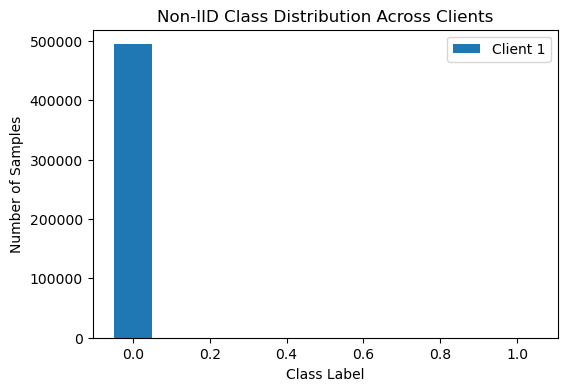



 BeFedG (CPU):
Round 0
Number of clusters in federated model: 81
Round 1
Number of clusters in federated model: 105
Round 2
Number of clusters in federated model: 135
Time: 45.54888558387756
Number of clusters in federated model: 135
ARI: 0.9798697836382889
NMI: 0.9455734411518788
ACC: 0.9956236678197891
Outside metrics: {'ARI': 0.9798697836382889, 'NMI': 0.9455734411518788, 'ACC': 0.9956236678197891}


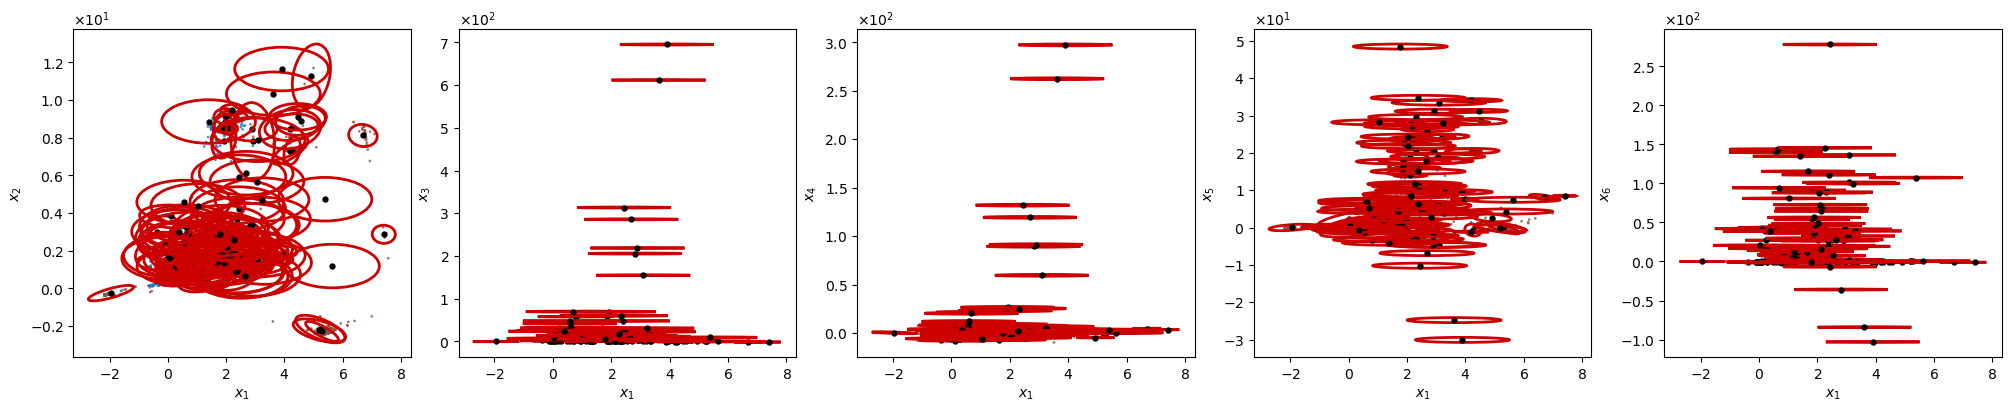

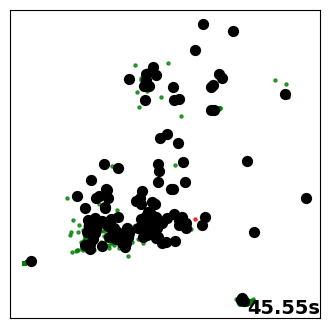

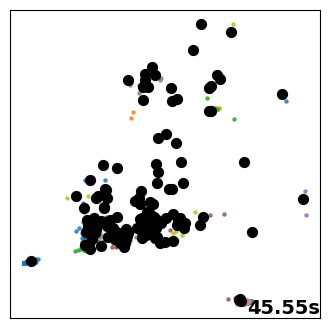

BeFedG_CPU Accuracy - Mean: 0.9956, Std: 0.0000
BeFedG_CPU nmi - Mean: 0.9456, Std: 0.0000
BeFedG_CPU ari - Mean: 0.9799, Std: 0.0000
BeFedG_CPU time - Mean: 45.5489, Std: 0.0000
BeFedG_CPU clusters - Mean: 135.0000, Std: 0.0000
BeFedG_GPU Accuracy - Mean: nan, Std: nan
BeFedG_GPU nmi - Mean: nan, Std: nan
BeFedG_GPU ari - Mean: nan, Std: nan
BeFedG_GPU time - Mean: nan, Std: nan
BeFedG_GPU clusters - Mean: nan, Std: nan
kFED Accuracy - Mean: nan, Std: nan
kFED nmi - Mean: nan, Std: nan
kFED ari - Mean: nan, Std: nan
kFED time - Mean: nan, Std: nan
kFED clusters - Mean: nan, Std: nan
MUFC Accuracy - Mean: nan, Std: nan
MUFC nmi - Mean: nan, Std: nan
MUFC ari - Mean: nan, Std: nan
MUFC time - Mean: nan, Std: nan
MUFC clusters - Mean: nan, Std: nan


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Timer unit: 1e-07 s

Total time: 67.794 s
File: C:\Users\Miha\AppData\Local\Temp\ipykernel_6512\2328621848.py
Function: run_benchmark_experiment at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def run_benchmark_experiment(X, y, local_model_params, federated_model_params, batch_size, feature_dim, num_clients, profiler_flag=False, debug_flag=0, unlabeled=0, name=None, flag_axis=True, flag_noniid=True, flag_plot=False):
     7                                               # Initialize dictionaries to store metrics for each method
     8         1         10.0     10.0      0.0      results = {
     9         1         23.0     23.0      0.0          'BeFedG_CPU': {'Accuracy': [], 'nmi': [], 'ari': [], 'time': [], 'clusters': []},
    10         1         12.0     12.0      0.0          'BeFedG_GPU': {'Accuracy': [], 'nmi': [], 'ari': [], 'time': [], 'clusters': []},
    11         1         13.0     13.0      0.0  

In [11]:


feature_dim = 10 #This defines the PCA dim reduction
X, y = load_data(feature_dim)

# Check dimensions
print("X shape:", X.shape)
print("y shape:", y.shape)

#X  = (X  - torch.min(X, dim=0)[0]) / (torch.max(X, dim=0)[0] - torch.min(X, dim=0)[0])

num_classes = 1
num_clients = 1
batch_size = int(np.ceil(len(y) / (num_clients*10)))

print("KDD99 Dataset",
    f"\n Samples:   {X.shape[0]}",
    f"\n Features:  {feature_dim}",
    f"\n Clients:   {num_clients}")

# Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": np.sqrt(feature_dim),
    "kappa_join": 0.7,
    "N_r": 1, #quantization, most important parameter
    "c_max": feature_dim,
    "kappa_features": 0,
    "device": None,
    "thr_relevance": 1  # 1-1e-6
}

federated_model_params = local_model_params

if 1:
    %load_ext line_profiler
    %lprun -f run_benchmark_experiment \
    -f train_supervised \
    -f eFedG.batch_clustering.__wrapped__ \
    -f MathOps.compute_batched_activation.__wrapped__ \
    -f ClusteringOps.batch_update_clusters \
    -f ClusteringOps.compute_fisher_scores \
    -f ClusteringOps.batch_increment_clusters \
    -f ClusteringOps.kmeans_plusplus_init \
    -f ClusteringOps.reduce_by_label \
    -f ClusteringOps.add_new_clusters\
    -f ClusteringOps.batch_update_global_statistics \
    -f MergingMechanism.batch_merging_mechanism \
    -f MergingMechanism.compute_kappa \
    -f MergingMechanism.find_pairs \
    -f MergingMechanism.perform_merge \
    -f FederalOps.federated_merging \
    -f RemovalMechanism.batch_update_scores \
    -f RemovalMechanism.remove_clusters \
    run_benchmark_experiment(X, y, local_model_params, federated_model_params, batch_size, feature_dim, num_clients, profiler_flag=False, debug_flag= 0, unlabeled=1, name = "NSL_KDD", flag_noniid=False, flag_plot= True)
elif 1:
    run_benchmark_experiment(X, y, local_model_params, federated_model_params, batch_size, feature_dim, num_clients,  profiler_flag=False, debug_flag=1, unlabeled=1, name="NSL_KDD", flag_noniid=False, flag_plot=True)

In [ ]:
import os

def run_experiment_and_save(feature_dim, num_clients):
    
    X = load_data(feature_dim)
    y = load_data('labels')
    batch_size = int(np.ceil(len(y) / (num_clients*feature_dim)))

    num_classes = 1
    print("NSL-KDD",
          f"\n Samples:   {X.shape[0]}",
          f"\n Features:  {feature_dim}",
          f"\n Classes:   {num_classes}",
          f"\n Clients:   {num_clients}")

    local_model_params = {
        "feature_dim": feature_dim,
        "num_classes": num_classes,
        "kappa_n": 1,
        "num_sigma": np.sqrt(feature_dim),
        "kappa_join": 1,
        "N_r":1,
        "c_max": 100,
        "kappa_features": 0,
        "device": None,
        "thr_relevance": 1
    }
    federated_model_params = local_model_params

    summary_results = run_benchmark_experiment(
        X, y, local_model_params, federated_model_params,
        batch_size, feature_dim, num_clients,
        profiler_flag=False, debug_flag=0, unlabeled=1,
        name="NSL_KDD", flag_axis=True, flag_noniid=False, flag_plot=False
    )

    results_data = []
    for method, metrics in summary_results.items():
        for metric, stats in metrics.items():
            results_data.append({
                'Method': method,
                'Metric': metric,
                'Mean': stats['mean'],
                'Std': stats['std'],
                'Feature_Dim': feature_dim,
                'Num_Clients': num_clients
            })
    results_df = pd.DataFrame(results_data)
    output_file = f".Results/Scale/NSL_KDD_dim_{feature_dim}_clients_{num_clients}.csv"
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

if 0:
    
    rounds = 1
    num_repetitions = 1
    feature_dims = [100, 10, 5]  # Different PCA dimensions to experiment with
    num_clients_list = [3, 10, 30]  # Different numbers of clients

    for feature_dim in feature_dims:
        for num_clients in num_clients_list:
            run_experiment_and_save(feature_dim, num_clients)


In [ ]:
if 0:

    metric_map = {
        'accuracy': 'Accuracy [\%]',
        'nmi': 'NMI',
        'ari': 'ARI',
        'time': 'Time (s)',
        'clusters': 'Clusters (\#)'
    }

    directory = '.Results/Scale/'

    results = {
        5: {
            3: {metric_map[key]: [] for key in metric_map},
            10: {metric_map[key]: [] for key in metric_map},
            30: {metric_map[key]: [] for key in metric_map}
        },
        10: {
            3: {metric_map[key]: [] for key in metric_map},
            10: {metric_map[key]: [] for key in metric_map},
            30: {metric_map[key]: [] for key in metric_map}
        },
        100: {
            3: {metric_map[key]: [] for key in metric_map},
            10: {metric_map[key]: [] for key in metric_map},
            30: {metric_map[key]: [] for key in metric_map}
        }
    }

    def process_file(filepath):

        df = pd.read_csv(filepath)
        grouped = df.groupby(['Method', 'Feature_Dim', 'Num_Clients', 'Metric'])
        mean_values = grouped[['Mean', 'Std']].mean().reset_index()

        for _, row in mean_values.iterrows():
            method, dim, clients, metric, mean_val, std_val = row['Method'], row['Feature_Dim'], row['Num_Clients'], row['Metric'], row['Mean'], row['Std']
            metric_key = metric_map[metric.lower()]  # Use the mapped metric key
            if metric.lower() == 'accuracy':
                mean_val *= 100  # Convert accuracy to percentage
                std_val *= 100   # Convert std deviation to percentage
                value_formatted = f"{mean_val:.1f}"+"{\pm}"+f"{std_val:.1f}"  # Format the mean and std dev in percentage
            elif metric.lower() in ['time', 'clusters']:
                value_formatted = f"{mean_val:.1f}"+"{\pm}"+f"{std_val:.1f}"  # Format with one decimal place
            else:
                value_formatted = f"{mean_val:.2f}"+"{\pm}"+f"{std_val:.2f}"  # Format with two decimal places
            
            results[dim][clients][metric_key].append((method, value_formatted))


    for filename in os.listdir(directory):
        if filename.startswith('NSL_KDD_dim_') and filename.endswith('.csv'):
            process_file(os.path.join(directory, filename))

    for dim in results:
        for clients in results[dim]:
            print(f"Feature Dimension: {dim}, Clients: {clients}")
            for metric, values in results[dim][clients].items():
                print(f"{metric}:")
                for value in values:
                    print(f"    {value[0]}: {value[1]}")
            print()


    def generate_latex_table(dataset, results):
        # LaTeX header
        latex_code = r"""
    \begin{table*}[h]
        \caption{Performance Comparison of Methods with Different dim Feature Reductions}
        \label{tab:performance_comparison}
        \centering
        \tiny
        \setlength{\tabcolsep}{3pt} % Adjust column separation here
        \begin{tabular}{l l l c c c c c c c c c c c c}
            \toprule
            \textbf{Dataset} & \textbf{dim} & \textbf{Metric} & \multicolumn{3}{c}{\textbf{BeFedG (CPU)}} & \multicolumn{3}{c}{\textbf{BeFedG (GPU)}} & \multicolumn{3}{c}{\textbf{kFED}} & \multicolumn{3}{c}{\textbf{MUFC}} \\
            \cmidrule(lr){4-6} \cmidrule(lr){7-9} \cmidrule(lr){10-12} \cmidrule(lr){13-15}
            & & & 3 & 10 & 30 & 3 & 10 & 30 & 3 & 10 & 30 & 3 & 10 & 30\\
            \midrule
        """

        dim_values = [5, 10, 100]
        metrics = ['Accuracy [\%]', 'NMI', 'ARI', 'Time (s)', 'Clusters (\#)']
        methods = ['BeFedG_CPU', 'BeFedG_GPU', '$k$-FED', 'MUFC']

        # Generate table content
        for dim_index, dim in enumerate(dim_values):
            if dim == 10:
                latex_code += r'\multirow{5}{*}{' + dataset + r'} & \multirow{5}{*}{' + str(dim) + r'}'
            else:
                latex_code += ' & \multirow{5}{*}{' + str(dim) + r'}'
            
            first_row = True
            for metric in metrics:
                if not first_row:
                    latex_code += '\n            & '
                else:
                    first_row = False

                latex_code += ' & ' + metric
                
                for method in methods:
                    client_data = []
                    for client in [3, 10, 30]:
                    
                        method_data = next((item for item in results[dim][client][metric] if item[0] == method), None)
                        if method_data:
                            client_data.append(method_data[1])  # Get the formatted string
                        else:
                            client_data.append('N/A')  # If no data, insert 'N/A'
                    
                    formatted_data = ' & '.join(client_data)
                    latex_code += f' & {formatted_data}'

                latex_code += r' \\' + '\n'
            

            if dim == 100:
                latex_code += r'        \midrule' + '\n'
            else:
                latex_code += r'        \cmidrule(lr){2-15}' + '\n'
            
        # End of table
        latex_code += r"""
            \bottomrule
        \end{tabular}
    \end{table*}
    """

        return latex_code

    def bold_best_values(results):
        bolded_results = {}
        for pca in results:
            bolded_results[pca] = {}
            for client in results[pca]:
                bolded_results[pca][client] = {metric: [] for metric in results[pca][client]}
                # Find best values
                max_acc = max((float(value[1].split('{\pm}')[0]), value) for value in results[pca][client]['Accuracy [\%]'])[1]
                max_nmi = max((float(value[1].split('{\pm}')[0]), value) for value in results[pca][client]['NMI'])[1]
                max_ari = max((float(value[1].split('{\pm}')[0]), value) for value in results[pca][client]['ARI'])[1]
                min_time = min((float(value[1].split('{\pm}')[0]), value) for value in results[pca][client]['Time (s)'])[1]

                # Apply bold formatting and replicate other entries
                for metric, values in results[pca][client].items():
                    for value in values:
                        if value == max_acc or value == max_nmi or value == max_ari or value == min_time:
                            bolded_results[pca][client][metric].append((value[0], f"$\\mathbf{{{value[1]}}}$"))
                        else:
                            bolded_results[pca][client][metric].append((value[0], f"${value[1]}$"))

        return bolded_results

    bolded_results = bold_best_values(results)

    for dim in bolded_results:
        for clients in bolded_results[dim]:
            print(f"Feature Dimension: {dim}, Clients: {clients}")
            for metric, values in bolded_results[dim][clients].items():
                print(f"{metric}:")
                for value in values:
                    print(f"    {value[0]}: {value[1]}")
            print()


    dataset = 'NSL-KDD'
    latex_code = generate_latex_table(dataset, bolded_results)
    print(latex_code)